<a id='top'></a>

# StatsBomb Data Engineering
##### Notebook to parse and engineer [StatsBomb](https://statsbomb.com/) event and 360 data from the [Open Data GitHub repository](https://github.com/statsbomb/open-data), as well as a provided set of OBV data, using [pandas](http://pandas.pydata.org/).

### By [Edd Webster](https://www.twitter.com/eddwebster)
Notebook first written: 10/01/2022<br>
Notebook last updated: 17/01/2022

![StatsBomb](../img/logos/stats-bomb-logo_small.png)

Click [here](#section4) to jump straight into the Data Engineering section and skip the [Notebook Brief](#section2) and [Data Sources](#section3) sections.

___


## <a id='introduction'>Introduction</a>
This notebook parses pubicly available [StatsBomb](https://statsbomb.com/) Event data, using [pandas](http://pandas.pydata.org/) for data manipulation through DataFrames.

For more information about this notebook and the author, I am available through all the following channels:
*    [eddwebster.com](https://www.eddwebster.com/);
*    edd.j.webster@gmail.com;
*    [@eddwebster](https://www.twitter.com/eddwebster);
*    [linkedin.com/in/eddwebster](https://www.linkedin.com/in/eddwebster/);
*    [github/eddwebster](https://github.com/eddwebster/); and
*    [public.tableau.com/profile/edd.webster](https://public.tableau.com/profile/edd.webster).

A static version of this notebook can be found [here](https://nbviewer.org/github/eddwebster/statsbomb/blob/main/notebooks/StatsBomb%20Data%20Engineering.ipynb). This notebook has an accompanying [`statsbomb`](https://github.com/eddwebster/statsbomb) GitHub repository and for my full repository of football analysis, see my [`football_analysis`](https://github.com/eddwebster/football_analytics) GitHub repository.

___

## <a id='notebook_contents'>Notebook Contents</a>
1.    [Notebook Dependencies](#section1)<br>
2.    [Notebook Brief](#section2)<br>
3.    [Data Sources](#section3)<br>
      1.    [Introduction](#section3.1)<br>
      2.    [Read in the Datasets](#section3.2)<br>
      3.    [Join the Datasets](#section3.3)<br>
      4.    [Initial Data Handling](#section3.4)<br>
4.    [Data Engineering](#section4)<br>
      1.    [Assign Raw DataFrame to Engineered DataFrame](#section4.1)<br>
      2.    [Rename Columns](#section4.2)<br>
      3.    [Drop Duplicate Columns](#section4.3)<br>
      4.    [Sort the DataFrame](#section4.4)<br>
      3.    [Determine Each Player's Most Frequent Position](#section4.3)<br>
      6.    [Determine Each Player's Total Minutes Played](#section4.6)<br>
      7.    [Break Down All location Attributes](#section4.7)<br>
5.    [Summary](#section5)<br>
6.    [Next Steps](#section6)<br>
7.    [References](#section7)<br>

___

<a id='section1'></a>

## <a id='#section1'>1. Notebook Dependencies</a>

This notebook was written using [Python 3](https://docs.python.org/3.7/) and requires the following libraries:
*    [`Jupyter notebooks`](https://jupyter.org/) for this notebook environment with which this project is presented;
*    [`NumPy`](http://www.numpy.org/) for multidimensional array computing; and
*    [`pandas`](http://pandas.pydata.org/) for data analysis and manipulation.

All packages used for this notebook can be obtained by downloading and installing the [Conda](https://anaconda.org/anaconda/conda) distribution, available on all platforms (Windows, Linux and Mac OSX). Step-by-step guides on how to install Anaconda can be found for Windows [here](https://medium.com/@GalarnykMichael/install-python-on-windows-anaconda-c63c7c3d1444) and Mac [here](https://medium.com/@GalarnykMichael/install-python-on-mac-anaconda-ccd9f2014072), as well as in the Anaconda documentation itself [here](https://docs.anaconda.com/anaconda/install/).

### Import Libraries and Modules

In [9]:
# Python ≥3.5 (ideally)
import platform
import sys, getopt
assert sys.version_info >= (3, 5)
import csv

# Import Dependencies
%matplotlib inline

# Math Operations
import numpy as np
from math import pi

# Datetime
import datetime
from datetime import date
import time

# Data Preprocessing
import pandas as pd
import pandas_profiling as pp
import os
import re
import chardet
import random
from io import BytesIO
from pathlib import Path

# Reading Directories
import glob
import os

# Working with JSON
import json
from pandas import json_normalize

# Data Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Requests and downloads
import tqdm
import requests

# Display in Jupyter
from IPython.display import Image, YouTubeVideo
from IPython.core.display import HTML

# Ignore Warnings
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Print message
print("Setup Complete")

Setup Complete


In [11]:
# Python / module versions used here for reference
print('Python: {}'.format(platform.python_version()))
print('NumPy: {}'.format(np.__version__))
print('pandas: {}'.format(pd.__version__))
print('matplotlib: {}'.format(mpl.__version__))

Python: 3.7.6
NumPy: 1.20.3
pandas: 1.3.2
matplotlib: 3.4.2


### Defined Filepaths

In [13]:
# Set up initial paths to subfolders
base_dir = os.path.join('..')
data_dir = os.path.join(base_dir, 'data')
img_dir = os.path.join(base_dir, 'img')
fig_dir = os.path.join(base_dir, 'img', 'fig')

### Create Directory Structure

In [14]:
# Make the directory structure
for folder in ['combined', 'competitions', 'events', 'tactics', 'lineups', 'three-sixty']:
    path = os.path.join(data_dir, 'raw', folder)
    if not os.path.exists(path):
        os.mkdir(path)

### Custom Functions

In [15]:
# Custom functions for downloading StatsBomb Open Data 

## Competitions
def load_file(season_id, getter="remote", path = None):
    resp = requests.get(f"https://raw.githubusercontent.com/statsbomb/open-data/master/data/matches/55/{season_id}.json")
    dict_season = json.loads(resp.text)
    df_season = json_normalize(dict_season, sep="_")
    return dict_season, df_season

## Match data
def load_match_file(match_id, getter="remote", path = None):
    resp = requests.get(f"https://raw.githubusercontent.com/statsbomb/open-data/master/data/events/{match_id}.json")
    dict_match = json.loads(resp.text)
    df = json_normalize(dict_match, sep="_")
    return dict_match, df

## 360 data
def load_three_sixty_file(match_id, getter="remote", path = None):
    resp = requests.get(f"https://raw.githubusercontent.com/statsbomb/open-data/master/data/three-sixty/{match_id}.json")
    dict_match = json.loads(resp.text)
    df = json_normalize(dict_match, sep="_")
    return dict_match, df

### Notebook Settings

In [16]:
# Display all columns of displayed pandas DataFrames
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.mode.chained_assignment = None

---

<a id='section2'></a>

## <a id='#section2'>2. Notebook Brief</a>
This notebook parses and engineers [StatsBomb](https://statsbomb.com/) event and 360 data from the [Open Data GitHub repository](https://github.com/statsbomb/open-data), as well as a provided set of OBV data, using [pandas](http://pandas.pydata.org/).


**Notebook Conventions**:<br>
*    Variables that refer a `DataFrame` object are prefixed with `df_`.
*    Variables that refer to a collection of `DataFrame` objects (e.g., a list, a set or a dict) are prefixed with `dfs_`.

---

<a id='section3'></a>

## <a id='#section3'>3. Data Sources</a>

<a id='section3.1'></a>

### <a id='#section3.1'>3.1. Introduction</a>
[StatsBomb](https://statsbomb.com/) are a  football analytics, data provider, and data visualisation and analytics tool company, founded by [Ted Knutson](https://twitter.com/mixedknuts). StatsBomb have brought common data analytics practices seen in business and tech to the world of football analytics. Through their platforms and products, StatsBomb offer immediate accessibility to valuable football insights from all major leagues and players across the globe.

![StatsBomb](../img/logos/stats-bomb-logo_small.png)

<a id='section3.2'></a>

### <a id='#section3.2'>3.2. Downloading, Parsing and Loading StatsBomb Data</a>
The following cells download the StatsBOmb Event and 360 data from the [StatsBomb Open Reposiory](https://github.com/statsbomb/open-data) on GitHub and read it as [pandas](https://pandas.pydata.org/) `DataFrame`s.

An additional CSV dataset of [StatsBomb OBV data](https://statsbomb.com/2021/09/introducing-on-ball-value-obv/) for EURO 2020 is imported as a pandas DataFrame and joined to the Event data, to further enrich the dataset.

These DataFrames are then unified to create a single dataset, from which the analysis of this task is based.

##### Event data

EURO 2020 has season_id = '43'. Uee that to extract the match_ids of the EURO 2020.

In [17]:
# EURO 2020 Season ID is 43
season_id = 43

In [18]:
# Create a list of Match IDs for the Season ID of interest
dict_season, df_season = load_file(season_id, getter="remote")    
lst_match_id = df_season.match_id.tolist() 

Now collect all the games into a single dataframe

In [19]:
# Create a single DataFrame of Event data

## Read in exported CSV file if exists, if not, download the latest JSON data
if not os.path.exists(os.path.join(data_dir, 'raw', 'events', 'events_euro_2020.csv')):
    
    ### Create an empty list of matches
    lst_matches = []

    ### Iterate through all the matches with the specified Season ID
    for i in tqdm.tqdm(range(len(lst_match_id)), desc='Loading all Matches'):
        dict_match, df = load_match_file(lst_match_id[i], getter="remote")
        df['match_id'] = lst_match_id[i]
        df['season_id'] = season_id
        lst_matches.append(df)

    ### Concatanate the Event data
    df_events = pd.concat(lst_matches)
    
    ### Export raw DataFrame
    df_events.to_csv(os.path.join(data_dir, 'raw', 'events', 'events_euro_2020.csv'), index=None, header=True)
    
    
## If already exists, read in previously saved DataFrame
else:
    
    ### Read in raw DataFrame
    df_events = pd.read_csv(os.path.join(data_dir, 'raw', 'events', 'events_euro_2020.csv'))
    
    
## Display DataFrame
df_events.head()

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (17,44,68,77,78,79,81,82,83,88,89,91,92,97,99,100,101,107,108,111,112,113,115,118,119,120,121,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,id,index,period,timestamp,minute,second,possession,duration,type_id,type_name,possession_team_id,possession_team_name,play_pattern_id,play_pattern_name,team_id,team_name,tactics_formation,tactics_lineup,related_events,location,player_id,player_name,position_id,position_name,pass_recipient_id,pass_recipient_name,pass_length,pass_angle,pass_height_id,pass_height_name,pass_end_location,pass_body_part_id,pass_body_part_name,pass_type_id,pass_type_name,carry_end_location,under_pressure,duel_type_id,duel_type_name,pass_aerial_won,counterpress,duel_outcome_id,duel_outcome_name,dribble_outcome_id,dribble_outcome_name,pass_outcome_id,pass_outcome_name,ball_receipt_outcome_id,ball_receipt_outcome_name,interception_outcome_id,interception_outcome_name,shot_statsbomb_xg,shot_end_location,shot_outcome_id,shot_outcome_name,shot_type_id,shot_type_name,shot_body_part_id,shot_body_part_name,shot_technique_id,shot_technique_name,shot_freeze_frame,goalkeeper_end_location,goalkeeper_type_id,goalkeeper_type_name,goalkeeper_position_id,goalkeeper_position_name,out,pass_outswinging,pass_technique_id,pass_technique_name,clearance_head,clearance_body_part_id,clearance_body_part_name,pass_switch,off_camera,pass_cross,clearance_left_foot,dribble_overrun,dribble_nutmeg,clearance_right_foot,pass_no_touch,foul_committed_advantage,foul_won_advantage,pass_assisted_shot_id,pass_shot_assist,shot_key_pass_id,shot_first_time,clearance_other,pass_miscommunication,clearance_aerial_won,pass_through_ball,ball_recovery_recovery_failure,goalkeeper_outcome_id,goalkeeper_outcome_name,goalkeeper_body_part_id,goalkeeper_body_part_name,shot_aerial_won,foul_committed_card_id,foul_committed_card_name,foul_committed_offensive,foul_won_defensive,substitution_outcome_id,substitution_outcome_name,substitution_replacement_id,substitution_replacement_name,50_50_outcome_id,50_50_outcome_name,pass_goal_assist,goalkeeper_technique_id,goalkeeper_technique_name,pass_cut_back,miscontrol_aerial_won,pass_straight,foul_committed_type_id,foul_committed_type_name,match_id,season_id,pass_inswinging,pass_deflected,injury_stoppage_in_chain,shot_one_on_one,bad_behaviour_card_id,bad_behaviour_card_name,shot_deflected,block_deflection,foul_committed_penalty,foul_won_penalty,block_save_block,goalkeeper_punched_out,player_off_permanent,shot_saved_off_target,goalkeeper_shot_saved_off_target,shot_saved_to_post,goalkeeper_shot_saved_to_post,shot_open_goal,goalkeeper_penalty_saved_to_post,dribble_no_touch,block_offensive,shot_follows_dribble,ball_recovery_offensive,shot_redirect,goalkeeper_lost_in_play,goalkeeper_success_in_play
0,9427b18a-6b10-411f-90da-3d6240b80c71,1,1,00:00:00.000,0,0,1,0.000000,35,Starting XI,1835,Finland,1,Regular Play,1835,Finland,352.0,"[{'player': {'id': 8667, 'name': 'Lukáš Hrádec...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3788753,43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,542c58bf-5c6c-43ca-9d8d-e086c7f08aaf,2,1,00:00:00.000,0,0,1,0.000000,35,Starting XI,1835,Finland,1,Regular Play,796,Russia,3421.0,"[{'player': {'id': 21298, 'name': 'Matvey Safo...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3788753,43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,a0dfe8a0-a0b9-4

In [20]:
df_events.shape

(192686, 144)

##### Matches

In [22]:
lst_competitions = ['55']

In [23]:
# Read in selected matches

## Read in exported CSV file if exists, if not, read in JSON file
if not os.path.exists(os.path.join(data_dir, 'raw', 'matches', 'matches_euro2020.csv')):
    
    ### Create empty list for DataFrames
    dfs_matches_all = []
    
    ### Loop through the selected competitions
    for competition in lst_competitions:

        ### Create empty list for DataFrames
        dfs_matches_competition = []
        
        #### Show files in directory
        lst_filepaths = list(glob.glob(data_dir + '/open-data/data/matches/' + str(competition) + '/*'))
            
        for filepath in lst_filepaths:
        
            ##### Open the JSON filepath with defined Competition and Season IDs
            try:

                ###### Import all StatsBomb JSON Match data for the mens matches
                with open(filepath) as f:
                    json_sb_match_data = json.load(f)

                ###### Flatten the JSON Match data
                df_matches = json_normalize(json_sb_match_data)

                ###### Append each Match data to 
                dfs_matches_competition.append(df_matches)

                ## Concatenate DataFrames to one DataFrame
                df_matches_competition = pd.concat(dfs_matches_competition)

            ##### If doesn't exist, skip
            except:
                pass

        ## Concatenate DataFrames to one DataFrame
        dfs_matches_all.append(df_matches_competition)
            
    ## Concatenate DataFrames to one DataFrame
    df_matches = pd.concat(dfs_matches_all)
    
## If DataFrame already exists, read in CSV file as a pandas DataFrame
else:    
    df_matches = pd.read_csv(os.path.join(data_dir, 'raw', 'matches', 'matches_euro2020.csv'))
    
    
## Display DataFrame
df_matches.head()

,match_id,match_date,kick_off,home_score,away_score,match_status,match_status_360,last_updated,last_updated_360,match_week,competition.competition_id,competition.country_name,competition.competition_name,season.season_id,season.season_name,home_team.home_team_id,home_team.home_team_name,home_team.home_team_gender,home_team.home_team_group,home_team.country.id,home_team.country.name,home_team.managers,away_team.away_team_id,away_team.away_team_name,away_team.away_team_gender,away_team.away_team_group,away_team.country.id,away_team.country.name,away_team.managers,metadata.data_version,metadata.shot_fidelity_version,metadata.xy_fidelity_version,competition_stage.id,competition_stage.name,stadium.id,stadium.name,stadium.country.id,stadium.country.name,referee.id,referee.name,referee.country.id,referee.country.name
0,3788753,2021-06-16,15:00:00.000,0,1,available,available,2021-11-11T14:00:16.105809,2021-09-22T16:39:05.697512,2,55,Europe,UEFA Euro,43,2020,1835,Finland,male,Group B,77,Finland,"[{'id': 3622, 'name': 'Markku Kanerva', 'nickn...",796,Russia,male,Group B,188,Russia,"[{'id': 365, 'name': 'Stanislav Cherchesov', '...",1.1.0,2,2,10,Group Stage,4726,Saint-Petersburg Stadium,188,Russia,293,Danny Desmond Makkelie,160,Netherlands
1,3788765,2021-06-20,18:00:00.000,3,1,available,available,2021-08-02T14:58:49.057,2021-11-11T13:54:37.507376,3,55,Europe,UEFA Euro,43,2020,773,Switzerland,male,Group A,221,Switzerland,"[{'id': 492, 'name': 'Vladimir Petković', 'nic...",909,Turkey,male,Group A,233,Turkey,"[{'id': 701, 'name': 'Şenol Güneş', 'nickname'...",1.1.0,2,2,10,Group Stage,4549,Bakı Olimpiya Stadionu,16,Azerbaijan,943,Slavko Vinčić,208,Slovenia
2,3795107,2021-07-02,21:00:00.000,1,2,available,available,2021-07-19T12:41:55.898,2021-09-23T00:02:51.495862,5,55,Europe,UEFA Euro,43,2020,782,Belgium,male,None,22,Belgium,"[{'id': 263, 'name': 'Roberto Martínez Montoli...",914,Italy,male,None,112,Italy,"[{'id': 2997, 'name': 'Roberto Mancini', 'nick...",1.1.0,2,2,11,Quarter-finals,4867,Allianz Arena (München),85,Germany,943,Slavko Vinčić,208,Slovenia
3,3795221,2021-07-07,21:00:00.000,2,1,available,available,2021-07-09T12:38:23.437,2021-09-22T22:33:37.494366,6,55,Europe,UEFA Euro,43,2020,768,England,male,None,68,England,"[{'id': 277, 'name': 'Gareth Southgate', 'nick...",776,Denmark,male,None,61,Denmark,"[{'id': 255, 'name': 'Kasper Hjulmand', 'nickn...",1.1.0,2,2,15,Semi-finals,4666,Wembley Stadium (London),68,England,293,Danny Desmond Makkelie,160,Netherlands
4,3795506,2021-07-11,21:00:00.000,1,1,available,available,2021-07-12T12:27:50.647,2021-09-22T22:40:31.690550,7,55,Europe,UEFA Euro,43,2020,914,Italy,male,None,112,Italy,"[{'id': 2997, 'name': 'Roberto Mancini', 'nick...",768,England,male,None,68,England,"[{'id': 277, 'name': 'Gareth Southgate', 'nick...",1.1.0,2,2,26,Final,4666,Wembley Stadium (London),68,England,287,Björn Kuipers,160,Netherlands


##### Teams

In [24]:
# Determine teams

## Select columns of interest
df_teams = df_matches[['match_id', 'match_date', 'competition.competition_id', 'home_team.home_team_name', 'away_team.away_team_name']].drop_duplicates()

## Replace dots in column names
df_teams.columns = df_teams.columns.str.replace(".", "_")

# Rename columns
df_teams = df_teams.rename(columns={'competition_competition_id': 'competition_id',
                                    'home_team_home_team_name': 'home_team_name',
                                    'away_team_away_team_name': 'away_team_name'
                                   }
                          )


## Order rows by Id
df_teams = df_teams.sort_values(['match_id'], ascending=[True])

## Reset index
df_teams = df_teams.reset_index(drop=True)

## Display DataFrame
df_teams.head(3)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  import sys


,match_id,match_date,competition_id,home_team_name,away_team_name
0,3788741,2021-06-11,55,Turkey,Italy
1,3788742,2021-06-12,55,Denmark,Finland
2,3788743,2021-06-12,55,Belgium,Russia


##### 360 data

In [25]:
# # Create a single DataFrame of 360 data

## Read in exported CSV file if exists, if not, download the latest JSON data
if not os.path.exists(os.path.join(data_dir, 'raw', 'three-sixty', 'three_sixty_euro_2020.csv')):
    
    ### Create empty list of StatsBomb 360 data
    lst_360_data = []

    ### 
    for i in tqdm.tqdm(range(len(lst_match_id)), desc='Loading all 360 data'):
        dict_match, df = load_three_sixty_file(lst_match_id[i], getter="remote")
        df['match_id'] = lst_match_id[i]
        df['season_id'] = season_id
        lst_360_data.append(df)

    ### 
    df_360_data = pd.concat(lst_360_data)
    
    ### Export raw DataFrame
    df_360_data.to_csv(os.path.join(data_dir, 'raw', 'three-sixty', 'three_sixty_euro_2020.csv'), index=None, header=True)
    
    
## If already exists, read in previously saved DataFrame
else:
    
    ### Read in raw DataFrame
    df_360_data = pd.read_csv(os.path.join(data_dir, 'raw', 'three-sixty', 'three_sixty_euro_2020.csv'))
    
    
## Display DataFrame
df_360_data.head()

,event_uuid,visible_area,freeze_frame,match_id,season_id
0,c943a37b-f9ae-4784-beb7-f9efce2ca855,"[117.46621424485, 0.0, 81.4292144844878, 80.0,...","[{'teammate': True, 'actor': True, 'keeper': F...",3788753,43
1,9ab10c7a-8de9-4ab3-9bdf-1c3383b6c817,"[120.0, 0.0, 120.0, 6.87142478029287, 84.96531...","[{'teammate': True, 'actor': False, 'keeper': ...",3788753,43
2,e9c92d0c-f223-4255-8aec-3a7f533d5e76,"[120.0, 0.0, 120.0, 6.87142478029287, 84.96531...","[{'teammate': False, 'actor': False, 'keeper':...",3788753,43
3,2bf9d325-fba4-4dfa-9f9f-08a25e70b073,"[120.0, 0.0, 120.0, 6.87142478029287, 84.96531...","[{'teammate': True, 'actor': False, 'keeper': ...",3788753,43
4,b8f60d23-03f4-4448-ab89-aa18e2db1258,"[120.0, 0.0, 120.0, 12.793109813798, 88.420824...","[{'teammate': True, 'actor': False, 'keeper': ...",3788753,43


In [26]:
# Print the shape of the DataFrame, df_360_data
print(df_events_raw.shape)

(172139, 5)

##### OBV data
Import OBV data provided in the email:

In [27]:
# Read in CSV data as a pandas DataFrame
df_euro_2020_obv = pd.read_csv(os.path.join(data_dir, 'raw', 'obv', 'euros_2020_obv.csv'))

##### Data unification
Join the Event data, Teams, 360, and OBV data together and export DataFrame as a CSV file: 

In [29]:
# Unify the three datasets into a single DataFrame and export as a CSV file

## Read in exported CSV file if exists, if not, merge the individual DataFrames
if not os.path.exists(os.path.join(data_dir, 'raw', 'combined', 'combined_euro_2020_360.csv')):
    
    ### Join the Teams DataFrame to the Events DataFrame
    df_events_raw = pd.merge(df_events, df_teams, left_on=['match_id'], right_on=['match_id'], how='left')
    
    ### Join the 360 DataFrame to the Events DataFrame
    df_events_raw = pd.merge(df_events_raw, df_360_data, left_on=['id'], right_on=['event_uuid'], how='left')

    ### Join the Competitions DataFrame to the Events-Matches DataFrame
    df_events_raw = pd.merge(df_events_raw, df_euro_2020_obv, left_on=['id'], right_on=['id'], how='left')
    
    ### Export raw DataFrame
    df_events_raw.to_csv(os.path.join(data_dir, 'raw', 'combined', 'combined_euro_2020_360.csv'), index=None, header=True)
    
## If already exists, read in previously saved DataFrame
else:
    
    ### Read in raw DataFrame
    df_events_raw = pd.read_csv(os.path.join(data_dir, 'raw', 'combined', 'combined_euro_2020_360.csv'))
    
    
## Display DataFrame
df_events_raw.head()

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (17,44,68,77,78,79,81,82,83,88,89,91,92,97,99,100,101,107,108,111,112,113,115,118,119,120,121,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,id,index,period,timestamp,minute,second,possession,duration,type_id,type_name,possession_team_id,possession_team_name,play_pattern_id,play_pattern_name,team_id,team_name,tactics_formation,tactics_lineup,related_events,location,player_id,player_name,position_id,position_name,pass_recipient_id,pass_recipient_name,pass_length,pass_angle,pass_height_id,pass_height_name,pass_end_location,pass_body_part_id,pass_body_part_name,pass_type_id,pass_type_name,carry_end_location,under_pressure,duel_type_id,duel_type_name,pass_aerial_won,counterpress,duel_outcome_id,duel_outcome_name,dribble_outcome_id,dribble_outcome_name,pass_outcome_id,pass_outcome_name,ball_receipt_outcome_id,ball_receipt_outcome_name,interception_outcome_id,interception_outcome_name,shot_statsbomb_xg,shot_end_location,shot_outcome_id,shot_outcome_name,shot_type_id,shot_type_name,shot_body_part_id,shot_body_part_name,shot_technique_id,shot_technique_name,shot_freeze_frame,goalkeeper_end_location,goalkeeper_type_id,goalkeeper_type_name,goalkeeper_position_id,goalkeeper_position_name,out,pass_outswinging,pass_technique_id,pass_technique_name,clearance_head,clearance_body_part_id,clearance_body_part_name,pass_switch,off_camera,pass_cross,clearance_left_foot,dribble_overrun,dribble_nutmeg,clearance_right_foot,pass_no_touch,foul_committed_advantage,foul_won_advantage,pass_assisted_shot_id,pass_shot_assist,shot_key_pass_id,shot_first_time,clearance_other,pass_miscommunication,clearance_aerial_won,pass_through_ball,ball_recovery_recovery_failure,goalkeeper_outcome_id,goalkeeper_outcome_name,goalkeeper_body_part_id,goalkeeper_body_part_name,shot_aerial_won,foul_committed_card_id,foul_committed_card_name,foul_committed_offensive,foul_won_defensive,substitution_outcome_id,substitution_outcome_name,substitution_replacement_id,substitution_replacement_name,50_50_outcome_id,50_50_outcome_name,pass_goal_assist,goalkeeper_technique_id,goalkeeper_technique_name,pass_cut_back,miscontrol_aerial_won,pass_straight,foul_committed_type_id,foul_committed_type_name,match_id_x,season_id_x,pass_inswinging,pass_deflected,injury_stoppage_in_chain,shot_one_on_one,bad_behaviour_card_id,bad_behaviour_card_name,shot_deflected,block_deflection,foul_committed_penalty,foul_won_penalty,block_save_block,goalkeeper_punched_out,player_off_permanent,shot_saved_off_target,goalkeeper_shot_saved_off_target,shot_saved_to_post,goalkeeper_shot_saved_to_post,shot_open_goal,goalkeeper_penalty_saved_to_post,dribble_no_touch,block_offensive,shot_follows_dribble,ball_recovery_offensive,shot_redirect,goalkeeper_lost_in_play,goalkeeper_success_in_play,match_date,competition_id,home_team_name,away_team_name,event_uuid,visible_area,freeze_frame,match_id_y,season_id_y,obv_total_net
0,9427b18a-6b10-411f-90da-3d6240b80c71,1,1,00:00:00.000,0,0,1,0.000000,35,Starting XI,1835,Finland,1,Regular Play,1835,Finland,352.0,"[{'player': {'id': 8667, 'name': 'Lukáš Hrádec...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3788753,43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-06-16,55,Finland,Russia,NaN,NaN,NaN,NaN,NaN,NaN
1,542c58bf-5c6c-43ca-9d8d-e086c7f08aaf,2,1,00:00:00.000,0,0,1,0.000000,35,Starting XI,1835,Finland,1,Regular Play,796,Russia,3421.0,"[{'player': {'id': 21298, 'name': 'Matvey Safo...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [30]:
# Check - before and after deduplication
print('No. rows in Events DataFrame BEFORE deduplication: {}'.format(len(df_events)))
print('No. rows in DataFrame AFTER deduplication: {}\n'.format(len(df_events_raw)))
print('-'*60+'\n')
print('Variance in rows BEFORE and AFTER deduplication: {}\n'.format(len(df_events_raw) - len(df_events)))

No. rows in Events DataFrame BEFORE deduplication: 192686
No. rows in DataFrame AFTER deduplication: 192686

------------------------------------------------------------

Variance in rows BEFORE and AFTER deduplication: 0



Now that the data has been read in, the next step is to conduct some preliminary Exploratory Data Analysis.

<a id='section3.3'></a>

### <a id='#section3.3'>3.3. Initial Data Handling</a>
First check the quality of the dataset by looking first and last rows in pandas using the [head()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.head.html) and [tail()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.tail.html) methods.

In [32]:
# Display the first five rows of the DataFrame, df_events_raw
df_events_raw.head()

,id,index,period,timestamp,minute,second,possession,duration,type_id,type_name,possession_team_id,possession_team_name,play_pattern_id,play_pattern_name,team_id,team_name,tactics_formation,tactics_lineup,related_events,location,player_id,player_name,position_id,position_name,pass_recipient_id,pass_recipient_name,pass_length,pass_angle,pass_height_id,pass_height_name,pass_end_location,pass_body_part_id,pass_body_part_name,pass_type_id,pass_type_name,carry_end_location,under_pressure,duel_type_id,duel_type_name,pass_aerial_won,counterpress,duel_outcome_id,duel_outcome_name,dribble_outcome_id,dribble_outcome_name,pass_outcome_id,pass_outcome_name,ball_receipt_outcome_id,ball_receipt_outcome_name,interception_outcome_id,interception_outcome_name,shot_statsbomb_xg,shot_end_location,shot_outcome_id,shot_outcome_name,shot_type_id,shot_type_name,shot_body_part_id,shot_body_part_name,shot_technique_id,shot_technique_name,shot_freeze_frame,goalkeeper_end_location,goalkeeper_type_id,goalkeeper_type_name,goalkeeper_position_id,goalkeeper_position_name,out,pass_outswinging,pass_technique_id,pass_technique_name,clearance_head,clearance_body_part_id,clearance_body_part_name,pass_switch,off_camera,pass_cross,clearance_left_foot,dribble_overrun,dribble_nutmeg,clearance_right_foot,pass_no_touch,foul_committed_advantage,foul_won_advantage,pass_assisted_shot_id,pass_shot_assist,shot_key_pass_id,shot_first_time,clearance_other,pass_miscommunication,clearance_aerial_won,pass_through_ball,ball_recovery_recovery_failure,goalkeeper_outcome_id,goalkeeper_outcome_name,goalkeeper_body_part_id,goalkeeper_body_part_name,shot_aerial_won,foul_committed_card_id,foul_committed_card_name,foul_committed_offensive,foul_won_defensive,substitution_outcome_id,substitution_outcome_name,substitution_replacement_id,substitution_replacement_name,50_50_outcome_id,50_50_outcome_name,pass_goal_assist,goalkeeper_technique_id,goalkeeper_technique_name,pass_cut_back,miscontrol_aerial_won,pass_straight,foul_committed_type_id,foul_committed_type_name,match_id_x,season_id_x,pass_inswinging,pass_deflected,injury_stoppage_in_chain,shot_one_on_one,bad_behaviour_card_id,bad_behaviour_card_name,shot_deflected,block_deflection,foul_committed_penalty,foul_won_penalty,block_save_block,goalkeeper_punched_out,player_off_permanent,shot_saved_off_target,goalkeeper_shot_saved_off_target,shot_saved_to_post,goalkeeper_shot_saved_to_post,shot_open_goal,goalkeeper_penalty_saved_to_post,dribble_no_touch,block_offensive,shot_follows_dribble,ball_recovery_offensive,shot_redirect,goalkeeper_lost_in_play,goalkeeper_success_in_play,match_date,competition_id,home_team_name,away_team_name,event_uuid,visible_area,freeze_frame,match_id_y,season_id_y,obv_total_net
0,9427b18a-6b10-411f-90da-3d6240b80c71,1,1,00:00:00.000,0,0,1,0.000000,35,Starting XI,1835,Finland,1,Regular Play,1835,Finland,352.0,"[{'player': {'id': 8667, 'name': 'Lukáš Hrádec...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3788753,43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-06-16,55,Finland,Russia,NaN,NaN,NaN,NaN,NaN,NaN
1,542c58bf-5c6c-43ca-9d8d-e086c7f08aaf,2,1,00:00:00.000,0,0,1,0.000000,35,Starting XI,1835,Finland,1,Regular Play,796,Russia,3421.0,"[{'player': {'id': 21298, 'name': 'Matvey Safo...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [33]:
# Display the last five rows of the DataFrame, df_events_raw
df_events_raw.tail()

,id,index,period,timestamp,minute,second,possession,duration,type_id,type_name,possession_team_id,possession_team_name,play_pattern_id,play_pattern_name,team_id,team_name,tactics_formation,tactics_lineup,related_events,location,player_id,player_name,position_id,position_name,pass_recipient_id,pass_recipient_name,pass_length,pass_angle,pass_height_id,pass_height_name,pass_end_location,pass_body_part_id,pass_body_part_name,pass_type_id,pass_type_name,carry_end_location,under_pressure,duel_type_id,duel_type_name,pass_aerial_won,counterpress,duel_outcome_id,duel_outcome_name,dribble_outcome_id,dribble_outcome_name,pass_outcome_id,pass_outcome_name,ball_receipt_outcome_id,ball_receipt_outcome_name,interception_outcome_id,interception_outcome_name,shot_statsbomb_xg,shot_end_location,shot_outcome_id,shot_outcome_name,shot_type_id,shot_type_name,shot_body_part_id,shot_body_part_name,shot_technique_id,shot_technique_name,shot_freeze_frame,goalkeeper_end_location,goalkeeper_type_id,goalkeeper_type_name,goalkeeper_position_id,goalkeeper_position_name,out,pass_outswinging,pass_technique_id,pass_technique_name,clearance_head,clearance_body_part_id,clearance_body_part_name,pass_switch,off_camera,pass_cross,clearance_left_foot,dribble_overrun,dribble_nutmeg,clearance_right_foot,pass_no_touch,foul_committed_advantage,foul_won_advantage,pass_assisted_shot_id,pass_shot_assist,shot_key_pass_id,shot_first_time,clearance_other,pass_miscommunication,clearance_aerial_won,pass_through_ball,ball_recovery_recovery_failure,goalkeeper_outcome_id,goalkeeper_outcome_name,goalkeeper_body_part_id,goalkeeper_body_part_name,shot_aerial_won,foul_committed_card_id,foul_committed_card_name,foul_committed_offensive,foul_won_defensive,substitution_outcome_id,substitution_outcome_name,substitution_replacement_id,substitution_replacement_name,50_50_outcome_id,50_50_outcome_name,pass_goal_assist,goalkeeper_technique_id,goalkeeper_technique_name,pass_cut_back,miscontrol_aerial_won,pass_straight,foul_committed_type_id,foul_committed_type_name,match_id_x,season_id_x,pass_inswinging,pass_deflected,injury_stoppage_in_chain,shot_one_on_one,bad_behaviour_card_id,bad_behaviour_card_name,shot_deflected,block_deflection,foul_committed_penalty,foul_won_penalty,block_save_block,goalkeeper_punched_out,player_off_permanent,shot_saved_off_target,goalkeeper_shot_saved_off_target,shot_saved_to_post,goalkeeper_shot_saved_to_post,shot_open_goal,goalkeeper_penalty_saved_to_post,dribble_no_touch,block_offensive,shot_follows_dribble,ball_recovery_offensive,shot_redirect,goalkeeper_lost_in_play,goalkeeper_success_in_play,match_date,competition_id,home_team_name,away_team_name,event_uuid,visible_area,freeze_frame,match_id_y,season_id_y,obv_total_net
192681,8aa68a18-79d2-4b8b-ba5f-9d3124f1cd20,2993,2,00:50:23.150,95,23,151,0.87093,30,Pass,907,Wales,4,From Throw In,907,Wales,NaN,NaN,"['a0bdd045-65d0-4601-9378-a5dacdba3257', 'dcbf...","[110.7, 0.1]",3086.0,Ben Davies,6.0,Left Back,6399.0,Gareth Frank Bale,6.103278,1.254227,2.0,Low Pass,"[112.6, 5.9]",NaN,NaN,67.0,Throw-in,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,Incomplete,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3788744,43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-06-12,55,Wales,Switzerland,NaN,NaN,NaN,NaN,NaN,NaN
192682,a0bdd045-65d0-4601-9378-a5dacdba3257,2994,2,00:50:24.021,95,24,151,NaN,42,Ball Receipt*,907,Wales,4,From Throw In,907,Wales,NaN,NaN,['8aa68a18-79d2-4b8b-ba5f-9d3124f1cd20'],"[113.7, 8.0]",6399.0,Gareth Frank Bale,16.0,Left Midfield,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,Incomplete,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [34]:
# Print the shape of the DataFrame, df_events_raw
print(df_events_raw.shape)

(192686, 154)


In [35]:
# Print the column names of the DataFrame, df_events_raw
print(df_events_raw.columns)

Index(['id', 'index', 'period', 'timestamp', 'minute', 'second', 'possession',
       'duration', 'type_id', 'type_name',
       ...
       'match_date', 'competition_id', 'home_team_name', 'away_team_name',
       'event_uuid', 'visible_area', 'freeze_frame', 'match_id_y',
       'season_id_y', 'obv_total_net'],
      dtype='object', length=154)


In [36]:
# Data types of the features of the raw DataFrame, df_events_raw
df_events_raw.dtypes

id                object
index              int64
period             int64
timestamp         object
minute             int64
                  ...   
visible_area      object
freeze_frame      object
match_id_y       float64
season_id_y      float64
obv_total_net    float64
Length: 154, dtype: object

Full details of these attributes and their data types is discussed further in the [Data Dictionary](section3.2.2).

In [37]:
# Displays all columns
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df_events_raw.dtypes)

id                                   object
index                                 int64
period                                int64
timestamp                            object
minute                                int64
second                                int64
possession                            int64
duration                            float64
type_id                               int64
type_name                            object
possession_team_id                    int64
possession_team_name                 object
play_pattern_id                       int64
play_pattern_name                    object
team_id                               int64
team_name                            object
tactics_formation                   float64
tactics_lineup                       object
related_events                       object
location                             object
player_id                           float64
player_name                          object
position_id                     

In [38]:
# Print statements about the dataset

## Define variables for print statments
count_matches = df_events_raw['match_id_x'].nunique() 
count_events = len(df_events_raw)
count_shots = len(df_events_raw[(df_events_raw['type_name'] == 'Shot')])
count_goals = len(df_events_raw[(df_events_raw['type_name'] == 'Shot') & (df_events_raw['shot_outcome_name'] == 'Goal')])
cols = list(df_events_raw)
count_event_type = len(df_events_raw['type_name'].unique())
vals_event_type = df_events_raw['type_name'].unique()

## Print statements
print(f'The EURO 2020 Events DataFrame contains the data for {count_matches:,} matches, of which there are {count_events:,} total events.\n')
print(f'Of these events, there are {count_shots:,} shots ({round(100*count_shots/count_events,1)}%) and {count_goals:,} goals ({round(100*count_goals/count_events,1)}%).\n')
print(f'This translates to a shot to goal conversion percentage of {round(100*count_goals/count_shots, 1)}%.\n')
print(f'The dataset contains the following features: {cols}\n')
print(f'The \'event_type\' column contain {count_event_type:,} different values, including the following: {vals_event_type}\n')    

The EURO 2020 Events DataFrame contains the data for 51 matches, of which there are 192,686 total events.

Of these events, there are 1,289 shots (0.7%) and 155 goals (0.1%).

This translates to a shot to goal conversion percentage of 12.0%.

The dataset contains the following features: ['id', 'index', 'period', 'timestamp', 'minute', 'second', 'possession', 'duration', 'type_id', 'type_name', 'possession_team_id', 'possession_team_name', 'play_pattern_id', 'play_pattern_name', 'team_id', 'team_name', 'tactics_formation', 'tactics_lineup', 'related_events', 'location', 'player_id', 'player_name', 'position_id', 'position_name', 'pass_recipient_id', 'pass_recipient_name', 'pass_length', 'pass_angle', 'pass_height_id', 'pass_height_name', 'pass_end_location', 'pass_body_part_id', 'pass_body_part_name', 'pass_type_id', 'pass_type_name', 'carry_end_location', 'under_pressure', 'duel_type_id', 'duel_type_name', 'pass_aerial_won', 'counterpress', 'duel_outcome_id', 'duel_outcome_name', 'drib

Counts of the event types:

In [39]:
# Shot outcomes types and their frequency
df_events_raw.groupby(['type_name']).type_name.count()

type_name
50/50                   56
Bad Behaviour           26
Ball Receipt*        52722
Ball Recovery         4443
Block                 1770
Carry                43800
Clearance             2283
Dispossessed          1087
Dribble               1475
Dribbled Past          894
Duel                  3354
Error                   24
Foul Committed        1394
Foul Won              1337
Goal Keeper           1514
Half End               244
Half Start             244
Injury Stoppage        288
Interception          1460
Miscontrol            1273
Offside                  9
Own Goal Against        11
Own Goal For            11
Pass                 54820
Player Off              22
Player On               21
Pressure             15955
Referee Ball-Drop      121
Shield                  58
Shot                  1289
Starting XI            102
Substitution           454
Tactical Shift         125
Name: type_name, dtype: int64

Counts of the outcome of all shots:

In [40]:
# Filter DataFrame for only shots and then groupby the 'typeName' (Event type) and count the number of each
df_events_raw[(df_events_raw['type_name'] == 'Shot')].groupby(['shot_outcome_name']).shot_outcome_name.count()

shot_outcome_name
Blocked             337
Goal                155
Off T               416
Post                 31
Saved               283
Saved Off Target      6
Saved to Post         5
Wayward              56
Name: shot_outcome_name, dtype: int64

There are eight outcomes of a shot: 'Blocked', 'Goal', 'Off T', 'Post', 'Saved', 'Saved Off Target', 'Saved to Post', 'Wayward'.

In [41]:
# Filter DataFrame for only shots and then groupby the 'typeName' (Event type) and count the number of each
df_events_raw[(df_events_raw['type_name'] == 'Shot')].groupby(['shot_type_name']).shot_type_name.count()

shot_type_name
Free Kick      41
Open Play    1193
Penalty        55
Name: shot_type_name, dtype: int64

In [42]:
# Info for the raw DataFrame, df_events_raw
df_events_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192686 entries, 0 to 192685
Columns: 154 entries, id to obv_total_net
dtypes: float64(37), int64(12), object(105)
memory usage: 226.4+ MB


<AxesSubplot:>

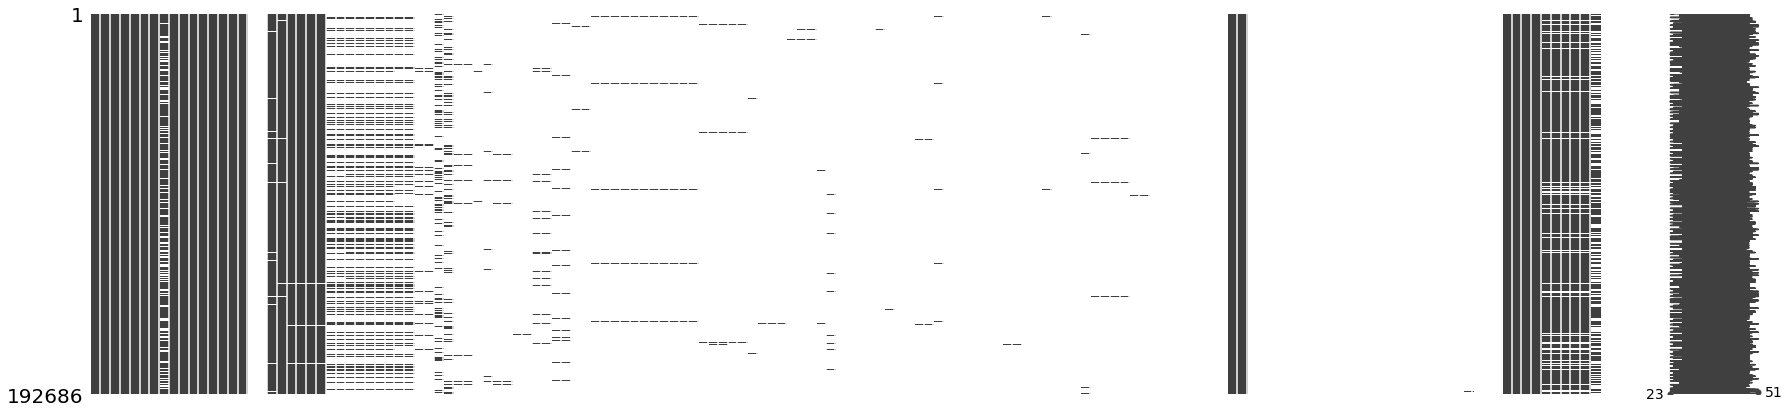

In [43]:
# Plot visualisation of the missing values for each feature of the raw DataFrame, df_shots_raw
msno.matrix(df_events_raw, figsize = (30, 7))

In [44]:
# Counts of missing values
null_value_stats = df_events_raw.isnull().sum(axis=0)
null_value_stats[null_value_stats != 0]

duration              52722
tactics_formation    192459
tactics_lineup       192459
related_events         7079
location               1530
                      ...  
visible_area          20547
freeze_frame          20547
match_id_y            20547
season_id_y           20547
obv_total_net         82697
Length: 133, dtype: int64

---

<a id='section4'></a>

## <a id='#section4'>4. Data Engineering</a>
The next ext step is to wrangle the dataset to into a format that’s suitable for analysis, through the creation of bespoke in-possession and out-of-possession metrics.

This section is broken down into the following subsections:

4.1.    [Assign Raw DataFrame to Engineered DataFrame](#section4.1)<br>
4.2.    [Rename Columns](#section4.2)<br>
4.2.    [Drop Duplicate Columns](#section4.3)<br>
4.4.    [Sort the DataFrame](#section4.4)<br>
4.5.    [Determine Each Player's Most Frequent Position](#section4.5)<br>
4.6.    [Determine Each Player's Total Minutes Played](#section4.6)<br>
4.7.    [Break Down All location Attributes](#section4.7)<br>

<a id='section4.1'></a>

### <a id='#section4.1'>4.1. Assign Raw DataFrame to Engineered DataFrame</a>

In [45]:
# Assign Raw DataFrame to Engineered DataFrame
df_events = df_events_raw

<a id='section4.2'></a>

### <a id='#section4.2'>4.2. Rename Columns</a>

In [46]:
# Rename columns
df_events = df_events.rename(columns={'match_id_x': 'match_id',
                                      'season_id_x': 'season_id'
                                     }
                            )

<a id='section4.3'></a>

### <a id='#section4.3'>4.3. Drop Unessassary  Columns</a>

In [47]:
# Drop duplicate columns
df_events = df_events.drop(['match_id_y', 'season_id_y'], axis=1)

<a id='section4.4'></a>

### <a id='#section4.4'>4.4. Sort DataFrame</a>
Sort DataFrame into correct order of events by time and date, required for creating accurate features.

In [49]:
# Sort DataFrame
#df_events = df_events.sort_values(['match_id', 'period', 'timestamp'], ascending=[True, True, True])    # this is not correct logic when consider extra time i.e. first minute of extra time is 91st min, but can proceed last minutes of regular time in injury time
#df_events = df_events.sort_values(['match_id', 'index'], ascending=[True, True])

<a id='section4.5'></a>

### <a id='#section4.5'>4.5. Determine Each Player's Most Frequent Playing Position</a>
A player's dominant position is determined as the most frequent position in which the player is playing in the Events data i.e. the highest count of Events in that position. 

The following determined positions will be used as the player's primary position

In [50]:
# Determine Each Player's Most Frequent Playing Position

## Groupby and Aggregate by player name and position
df_player_positions = (df_events
                           .groupby(['player_name', 'player_id', 'team_name', 'position_name'])
                           .agg({'type_name': 'count'})
                           .reset_index()
                      )

## Rename columns after groupby and aggregation
df_player_positions.columns = ['player_name', 'player_id', 'team_name', 'primary_position_name', 'count']

## Drop level
#df_player_positions.columns = df_player_positions.columns.droplevel(level=0)

## Reset index
df_player_positions = df_player_positions.reset_index()

## Sort by 'count of events' decending
df_player_positions = df_player_positions.sort_values(['player_name', 'count'], ascending=[True, False])

## Groupby position and drop the counts
df_player_positions = (df_player_positions
                           .groupby(['player_name', 'team_name']).head(1)
                           .drop(['index', 'count'], axis=1)
                      )

## Display DataFrame
df_player_positions.head(5)

,player_name,player_id,team_name,primary_position_name
2,Aaron Ramsey,3517.0,Wales,Left Center Midfield
3,Adam Hložek,28239.0,Czech Republic,Left Wing
6,Adama Traoré Diarra,11333.0,Spain,Right Back
8,Admir Mehmedi,8219.0,Switzerland,Left Center Forward
11,Adrien Rabiot,3026.0,France,Left Center Midfield


Aggregate the positions into Goalkeepers, Defenders, Midfielders, and Forwards.

In [51]:
# Show all unique values for position
df_events['position_name'].unique()

array([nan, 'Right Attacking Midfield', 'Center Back',
       'Left Attacking Midfield', 'Center Defensive Midfield',
       'Left Wing Back', 'Center Forward', 'Right Wing Back',
       'Left Defensive Midfield', 'Right Defensive Midfield',
       'Right Center Back', 'Left Center Back', 'Goalkeeper',
       'Left Center Forward', 'Right Center Forward',
       'Right Center Midfield', 'Left Center Midfield',
       'Center Attacking Midfield', 'Right Midfield', 'Right Back',
       'Left Midfield', 'Left Back', 'Left Wing', 'Right Wing'],
      dtype=object)

In [52]:
# Map a defined dictionary of grouped positions, per specific position

## Define a dictionary of positions
dict_positions_grouped = {'Goalkeeper': 'Goalkeeper',
                          'Left Center Back': 'Defender',
                          'Center Back': 'Defender',
                          'Right Center Back': 'Defender',
                          'Left Back': 'Defender',
                          'Right Back': 'Defender',
                          'Left Wing Back': 'Defender',
                          'Right Wing Back': 'Defender',
                          'Left Defensive Midfield': 'Midfield',
                          'Center Defensive Midfield': 'Midfield',
                          'Right Defensive Midfield': 'Midfield',
                          'Left Center Midfield': 'Midfield',
                          'Center Midfield': 'Midfield',
                          'Right Center Midfield': 'Midfield',
                          'Left Midfield': 'Midfield',
                          'Right Midfield': 'Midfield',
                          'Left Attacking Midfield': 'Midfield',
                          'Right Attacking Midfield': 'Midfield',
                          'Center Attacking Midfield': 'Midfield',
                          'Left Center Forward': 'Forward',
                          'Center Forward': 'Forward',
                          'Right Center Forward': 'Forward',
                          'Left Wing': 'Forward',
                          'Right Wing': 'Forward',
                          'Secondary Striker': 'Forward'
                         }

## Map grouped positions to DataFrame
df_player_positions['primary_position_name_grouped'] = df_player_positions['primary_position_name'].map(dict_positions_grouped)

In [53]:
# Show all unique values for position
df_player_positions['primary_position_name_grouped'].unique()

array(['Midfield', 'Forward', 'Defender', 'Goalkeeper'], dtype=object)

Finally, create an `outfield_goalkeeper` attribute.

In [54]:
# Separate Goalkeepers and Outfielders
df_player_positions['outfielder_goalkeeper'] = np.where(df_player_positions['primary_position_name'].isnull(), np.nan, (np.where(df_player_positions['primary_position_name'] == 'Goalkeeper', 'Goalkeeper', 'Outfielder')))

In [56]:
# Join onto the Events DataFrame
#df_events = pd.merge(df_events, df_player_positions, left_on=['player_name'], right_on=['player_name'], how='left')

<a id='section4.6'></a>

### <a id='#section4.6'>4.6. Determine Each Player's Total Minutes</a>

In [57]:
# Determine Each Player's Total Minutes Played

## Groupby and Aggregate by player name and position
df_player_minutes = (df_events
                         .groupby(['player_name', 'match_id'])
                         .agg({'minute': ['min', 'max']})
                    )

## Drop level
df_player_minutes.columns = df_player_minutes.columns.droplevel(level=0)

## Reset index
df_player_minutes = df_player_minutes.reset_index()


## Reset 'min_start'
df_player_minutes['min'] = np.where(df_player_minutes['min'] <= 5, 0, df_player_minutes['min']) 

## Determine the total minutes played per match
df_player_minutes['mins_total'] = df_player_minutes['max'] - df_player_minutes['min'] 

## Sum the total minutes played
df_player_minutes = (df_player_minutes
                            .groupby(['player_name'])
                            .agg({'mins_total': ['sum']})
                       )

## Reset index
df_player_minutes = df_player_minutes.reset_index()

## Rename columns after groupby and aggregation
df_player_minutes.columns = ['player_name', 'mins_total']

## Sort by 'mins_total' decending
df_player_minutes = df_player_minutes.sort_values(['mins_total'], ascending=[False])

## Display DataFrame
df_player_minutes.head(5)

,player_name,mins_total
144,Gianluigi Donnarumma,729
197,Jorge Luiz Frello Filho,721
195,Jordan Pickford,699
250,Leonardo Bonucci,681
190,John Stones,679


In [58]:
# Join onto the Events DataFrame
df_events = pd.merge(df_events, df_player_minutes, left_on=['player_name'], right_on=['player_name'], how='left')

<a id='section4.7'></a>

### <a id='#section4.7'>4.7. Break Down All `location` Attributes</a>
Separate all location attributes for X, Y (and sometimes Z) coordinates

In [59]:
# Display all location columns
for col in df_events.columns:
    if 'location' in col:
        print(col)

location
pass_end_location
carry_end_location
shot_end_location
goalkeeper_end_location


There are the following five 'location' attributes:
- `location`
- `pass.end_location`
- `carry.end_location`
- `shot.end_location`
- `goalkeeper.end_location`

From reviewing the official documentation [[link](https://statsbomb.com/stat-definitions/)], the five attributes have the following dimensionality:
- `location` [x, y]
- `pass.end_location` [x, y]
- `carry.end_location` [x, y]
- `shot.end_location` [x, y, z]
- `goalkeeper.end_location` [x, y]

In [60]:
# Break Down All location Attributes - slightly clunky code, but works, so not replaced with a loop or regex yet

df_events['location'] = df_events['location'].astype(str)
df_events['pass_end_location'] = df_events['pass_end_location'].astype(str)
df_events['carry_end_location'] = df_events['carry_end_location'].astype(str)
df_events['shot_end_location'] = df_events['shot_end_location'].astype(str)
df_events['goalkeeper_end_location'] = df_events['goalkeeper_end_location'].astype(str)


df_events['location'] = df_events['location'].str.replace('[','')
df_events['pass_end_location'] = df_events['pass_end_location'].str.replace('[','')
df_events['carry_end_location'] = df_events['carry_end_location'].str.replace('[','')
df_events['shot_end_location'] = df_events['shot_end_location'].str.replace('[','')
df_events['goalkeeper_end_location'] = df_events['goalkeeper_end_location'].str.replace('[','')


df_events['location'] = df_events['location'].str.replace(']','')
df_events['pass_end_location'] = df_events['pass_end_location'].str.replace(']','')
df_events['carry_end_location'] = df_events['carry_end_location'].str.replace(']','')
df_events['shot_end_location'] = df_events['shot_end_location'].str.replace(']','')
df_events['goalkeeper_end_location'] = df_events['goalkeeper_end_location'].str.replace(']','')


df_events['location_x'], df_events['location_y'] = df_events['location'].str.split(',', 1).str
df_events['pass_end_location_x'], df_events['pass_end_location_y'] = df_events['pass_end_location'].str.split(',', 1).str
df_events['carry_end_location_x'], df_events['carry_end_location_y'] = df_events['carry_end_location'].str.split(',', 1).str
df_events['shot_end_location_x'], df_events['shot_end_location_y'], df_events['shot_end_location_z'] = df_events['shot_end_location'].str.split(',', 3).str[0:3].str
df_events['goalkeeper_end_location_x'], df_events['goalkeeper_end_location_y'] = df_events['goalkeeper_end_location'].str.split(',', 1).str


df_events['location_x'] = df_events['location_x'].astype(float)
df_events['location_y'] = df_events['location_y'].astype(float)
df_events['pass_end_location_x'] = df_events['pass_end_location_x'].astype(float)
df_events['pass_end_location_y'] = df_events['pass_end_location_y'].astype(float)
df_events['carry_end_location_x'] = df_events['carry_end_location_x'].astype(float)
df_events['carry_end_location_y'] = df_events['carry_end_location_y'].astype(float)
df_events['shot_end_location_x'] = df_events['shot_end_location_x'].astype(float)
df_events['shot_end_location_y'] = df_events['shot_end_location_y'].astype(float)
df_events['goalkeeper_end_location_x'] = df_events['goalkeeper_end_location_x'].astype(float)
df_events['goalkeeper_end_location_y'] = df_events['goalkeeper_end_location_y'].astype(float)

## Display DataFrame
df_events.head(5)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  # This is added back by InteractiveShellApp.init_path()
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  if sys.path[0] == '':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  del sys.path[0]
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: The

,id,index,period,timestamp,minute,second,possession,duration,type_id,type_name,possession_team_id,possession_team_name,play_pattern_id,play_pattern_name,team_id,team_name,tactics_formation,tactics_lineup,related_events,location,player_id,player_name,position_id,position_name,pass_recipient_id,pass_recipient_name,pass_length,pass_angle,pass_height_id,pass_height_name,pass_end_location,pass_body_part_id,pass_body_part_name,pass_type_id,pass_type_name,carry_end_location,under_pressure,duel_type_id,duel_type_name,pass_aerial_won,counterpress,duel_outcome_id,duel_outcome_name,dribble_outcome_id,dribble_outcome_name,pass_outcome_id,pass_outcome_name,ball_receipt_outcome_id,ball_receipt_outcome_name,interception_outcome_id,interception_outcome_name,shot_statsbomb_xg,shot_end_location,shot_outcome_id,shot_outcome_name,shot_type_id,shot_type_name,shot_body_part_id,shot_body_part_name,shot_technique_id,shot_technique_name,shot_freeze_frame,goalkeeper_end_location,goalkeeper_type_id,goalkeeper_type_name,goalkeeper_position_id,goalkeeper_position_name,out,pass_outswinging,pass_technique_id,pass_technique_name,clearance_head,clearance_body_part_id,clearance_body_part_name,pass_switch,off_camera,pass_cross,clearance_left_foot,dribble_overrun,dribble_nutmeg,clearance_right_foot,pass_no_touch,foul_committed_advantage,foul_won_advantage,pass_assisted_shot_id,pass_shot_assist,shot_key_pass_id,shot_first_time,clearance_other,pass_miscommunication,clearance_aerial_won,pass_through_ball,ball_recovery_recovery_failure,goalkeeper_outcome_id,goalkeeper_outcome_name,goalkeeper_body_part_id,goalkeeper_body_part_name,shot_aerial_won,foul_committed_card_id,foul_committed_card_name,foul_committed_offensive,foul_won_defensive,substitution_outcome_id,substitution_outcome_name,substitution_replacement_id,substitution_replacement_name,50_50_outcome_id,50_50_outcome_name,pass_goal_assist,goalkeeper_technique_id,goalkeeper_technique_name,pass_cut_back,miscontrol_aerial_won,pass_straight,foul_committed_type_id,foul_committed_type_name,match_id,season_id,pass_inswinging,pass_deflected,injury_stoppage_in_chain,shot_one_on_one,bad_behaviour_card_id,bad_behaviour_card_name,shot_deflected,block_deflection,foul_committed_penalty,foul_won_penalty,block_save_block,goalkeeper_punched_out,player_off_permanent,shot_saved_off_target,goalkeeper_shot_saved_off_target,shot_saved_to_post,goalkeeper_shot_saved_to_post,shot_open_goal,goalkeeper_penalty_saved_to_post,dribble_no_touch,block_offensive,shot_follows_dribble,ball_recovery_offensive,shot_redirect,goalkeeper_lost_in_play,goalkeeper_success_in_play,match_date,competition_id,home_team_name,away_team_name,event_uuid,visible_area,freeze_frame,obv_total_net,mins_total,location_x,location_y,pass_end_location_x,pass_end_location_y,carry_end_location_x,carry_end_location_y,shot_end_location_x,shot_end_location_y,shot_end_location_z,goalkeeper_end_location_x,goalkeeper_end_location_y
0,9427b18a-6b10-411f-90da-3d6240b80c71,1,1,00:00:00.000,0,0,1,0.000000,35,Starting XI,1835,Finland,1,Regular Play,1835,Finland,352.0,"[{'player': {'id': 8667, 'name': 'Lukáš Hrádec...",NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,NaN,NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3788753,43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-06-16,55,Finland,Russia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,542c58bf-5c6c-43ca-9d8d-e086c7f08aaf,2,1,00:00:00.000,0,0,1,0.000000,35,Starting XI,1835,Finland,1,Regular Play,796,Russia,3421.0,"[{'player': {'id': 21298, 'name': 'Matvey Safo...",NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,NaN,NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN,N

<a id='section4.8'></a>

### <a id='#section4.8'>4.8. Create New Attributes</a>

Baseline attributes required for determining in-possession and out-of-possession metrics in later section:
*    **Team**: the team or in this case, the country that the player is playing for;
*    **Opponent**: the team or in this case, the country that the player is playing against;
*    **Minutes played**: the number of minutes played; and
*    **Games played**: the total number of matches played (for the aggregated version only).

In [61]:
# Create New Attributes
df_events['next_event'] = df_events['type_name'].shift(-1)
df_events['previous_event'] = df_events['type_name'].shift(+1)
df_events['next_team_possession'] = df_events['possession_team_name'].shift(-1)
df_events['previous_team_possession'] = df_events['possession_team_name'].shift(+1)
df_events['possession_retained'] = np.where((df_events['possession_team_name'] == df_events['next_team_possession']), 1, 0)
df_events['endloc_x'] = np.where(df_events['type_name'] == 'Pass', df_events['pass_end_location_x'], np.where(df_events['type_name'] == 'Carry', df_events['carry_end_location_x'], df_events['location_x']))
df_events['endloc_y'] = np.where(df_events['type_name'] == 'Pass', df_events['pass_end_location_y'], np.where(df_events['type_name'] == 'Carry', df_events['carry_end_location_y'], df_events['location_y']))
df_events['dist1'] = np.sqrt((df_events['location_x'] - 120)**2 + (df_events['location_y'] - 40)**2)
df_events['dist2'] = np.sqrt((df_events['endloc_x'] - 120)**2 + (df_events['endloc_y'] - 40)**2)
df_events['diffdist'] = df_events['dist1'] - df_events['dist2']

# Display DataFrame
df_events.head()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  # Remove the CWD from sys.path while we load stuff.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  # This is added back by InteractiveShellApp.init_path()


,id,index,period,timestamp,minute,second,possession,duration,type_id,type_name,possession_team_id,possession_team_name,play_pattern_id,play_pattern_name,team_id,team_name,tactics_formation,tactics_lineup,related_events,location,player_id,player_name,position_id,position_name,pass_recipient_id,pass_recipient_name,pass_length,pass_angle,pass_height_id,pass_height_name,pass_end_location,pass_body_part_id,pass_body_part_name,pass_type_id,pass_type_name,carry_end_location,under_pressure,duel_type_id,duel_type_name,pass_aerial_won,counterpress,duel_outcome_id,duel_outcome_name,dribble_outcome_id,dribble_outcome_name,pass_outcome_id,pass_outcome_name,ball_receipt_outcome_id,ball_receipt_outcome_name,interception_outcome_id,interception_outcome_name,shot_statsbomb_xg,shot_end_location,shot_outcome_id,shot_outcome_name,shot_type_id,shot_type_name,shot_body_part_id,shot_body_part_name,shot_technique_id,shot_technique_name,shot_freeze_frame,goalkeeper_end_location,goalkeeper_type_id,goalkeeper_type_name,goalkeeper_position_id,goalkeeper_position_name,out,pass_outswinging,pass_technique_id,pass_technique_name,clearance_head,clearance_body_part_id,clearance_body_part_name,pass_switch,off_camera,pass_cross,clearance_left_foot,dribble_overrun,dribble_nutmeg,clearance_right_foot,pass_no_touch,foul_committed_advantage,foul_won_advantage,pass_assisted_shot_id,pass_shot_assist,shot_key_pass_id,shot_first_time,clearance_other,pass_miscommunication,clearance_aerial_won,pass_through_ball,ball_recovery_recovery_failure,goalkeeper_outcome_id,goalkeeper_outcome_name,goalkeeper_body_part_id,goalkeeper_body_part_name,shot_aerial_won,foul_committed_card_id,foul_committed_card_name,foul_committed_offensive,foul_won_defensive,substitution_outcome_id,substitution_outcome_name,substitution_replacement_id,substitution_replacement_name,50_50_outcome_id,50_50_outcome_name,pass_goal_assist,goalkeeper_technique_id,goalkeeper_technique_name,pass_cut_back,miscontrol_aerial_won,pass_straight,foul_committed_type_id,foul_committed_type_name,match_id,season_id,pass_inswinging,pass_deflected,injury_stoppage_in_chain,shot_one_on_one,bad_behaviour_card_id,bad_behaviour_card_name,shot_deflected,block_deflection,foul_committed_penalty,foul_won_penalty,block_save_block,goalkeeper_punched_out,player_off_permanent,shot_saved_off_target,goalkeeper_shot_saved_off_target,shot_saved_to_post,goalkeeper_shot_saved_to_post,shot_open_goal,goalkeeper_penalty_saved_to_post,dribble_no_touch,block_offensive,shot_follows_dribble,ball_recovery_offensive,shot_redirect,goalkeeper_lost_in_play,goalkeeper_success_in_play,match_date,competition_id,home_team_name,away_team_name,event_uuid,visible_area,freeze_frame,obv_total_net,mins_total,location_x,location_y,pass_end_location_x,pass_end_location_y,carry_end_location_x,carry_end_location_y,shot_end_location_x,shot_end_location_y,shot_end_location_z,goalkeeper_end_location_x,goalkeeper_end_location_y,next_event,previous_event,next_team_possession,previous_team_possession,possession_retained,endloc_x,endloc_y,dist1,dist2,diffdist
0,9427b18a-6b10-411f-90da-3d6240b80c71,1,1,00:00:00.000,0,0,1,0.000000,35,Starting XI,1835,Finland,1,Regular Play,1835,Finland,352.0,"[{'player': {'id': 8667, 'name': 'Lukáš Hrádec...",NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,NaN,NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3788753,43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-06-16,55,Finland,Russia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Starting XI,NaN,Finland,NaN,1,NaN,NaN,NaN,NaN,NaN
1,542c58bf-5c6c-43ca-9d8d-e086c7f08aaf,2,1,00:00:00.000,0,0,1,0.000000,35,Starting XI,1835,Finland,1

---

<a id='section5'></a>

## <a id='#section5'>5. Export Final DataFrames</a>

In [ ]:
# Export DataFrame
df_events.to_csv(os.path.join(data_dir, 'engineered', 'combined', 'euro2020', 'combined_euro_2020_360.csv'), index=None, header=True)

---

<a id='section6'></a>

## <a id='#section6'>6. Summary</a>
This notebook  parse and engineer [StatsBomb](https://statsbomb.com/) Event, 360 data, and OBV from the [Open Data GitHub repository](https://github.com/statsbomb/open-data) using [pandas](http://pandas.pydata.org/).

---

<a id='section7'></a>

## <a id='#section7'>7. Next Steps</a>
The next stage is to visualise this data and create the scripts that can be used to create visuals, which can be found in the [StatsBomb EURO 2020 Data Visualisation](https://github.com/eddwebster/statsbomb/blob/main/notebooks/StatsBomb%20EURO%202020%20Data%20Visualisation.ipynb) notebook and subsequent, productionised [`WebsterViz`](https://github.com/eddwebster/statsbomb/blob/main/scripts/WebsterViz.py) script.

---

<a id='section8'></a>

## <a id='#section8'>8. References</a>
*    [StatsBomb](https://statsbomb.com/) data
*    [StatsBomb open data](https://github.com/statsbomb/open-data/tree/master/data): A respository with StatsBomb open data.
*    [StatsBombPy](https://github.com/statsbomb/statsbombpy) | [StatsBombR](https://github.com/statsbomb/StatsBombR): Libraries to facilitate fetching StatsBomb data.
*    [Open Data Documentation](https://github.com/statsbomb/open-data/tree/master/doc):
     +    [Open Data Competitions v2.0.0](https://github.com/statsbomb/open-data/blob/master/doc/Open%20Data%20Competitions%20v2.0.0.pdf).pdf describes the JSON format of the competitions.json file in the data.
     +    [Open Data Events v4.0.0](https://github.com/statsbomb/open-data/blob/master/doc/Open%20Data%20Events%20v4.0.0.pdf).pdf describes the format of the event JSON files in the data/events/ directory.
     +    [Open Data Lineups v2.0.0](https://github.com/statsbomb/open-data/blob/master/doc/Open%20Data%20Lineups%20v2.0.0.pdf).pdf describes the format of the lineup JSON files in the data/lineups/ folder.
     +    [Open Data Matches v3.0.0](https://github.com/statsbomb/open-data/blob/master/doc/Open%20Data%20Matches%20v3.0.0.pdf).pdf describes the format of the match listing JSON files in the data/matches/ folder.
     +    [Open Data 360 Frames v1.0.0.pdf](https://github.com/statsbomb/open-data/blob/master/doc/Open%20Data%20360%20Frames%20v1.0.0.pdf) document describes the JSON format for StatsBomb’s open 360 data.
     +    [StatsBomb Open Data Specification v1.1](https://github.com/statsbomb/open-data/blob/master/doc/StatsBomb%20Open%20Data%20Specification%20v1.1.pdf).pdf gives detail about the meaning an attributes of specific events in the data.
*    [Introducing On-Ball Value (OBV)](https://statsbomb.com/2021/09/introducing-on-ball-value-obv/)

---

***Visit my website [eddwebster.com](https://www.eddwebster.com) or my [GitHub Repository](https://github.com/eddwebster) for more projects. If you'd like to get in contact, my Twitter handle is [@eddwebster](http://www.twitter.com/eddwebster) and my email is: edd.j.webster@gmail.com.***

[Back to the top](#top)